# Whole-exome sequencing mutations

In [1]:
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")
options(repr.plot.width=8, repr.plot.height=8)

options("readr.num_columns" = 0)

# read switch information
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1)

# read mutual exclusion info
wes <- read_tsv("../data/pancancer/mutations/gene_functional_mutations_all_switches.txt") %>%
    mutate(co = MS/(MS+S)) %>%
    merge(switches,all=T)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


## Overview

Loading required package: RColorBrewer


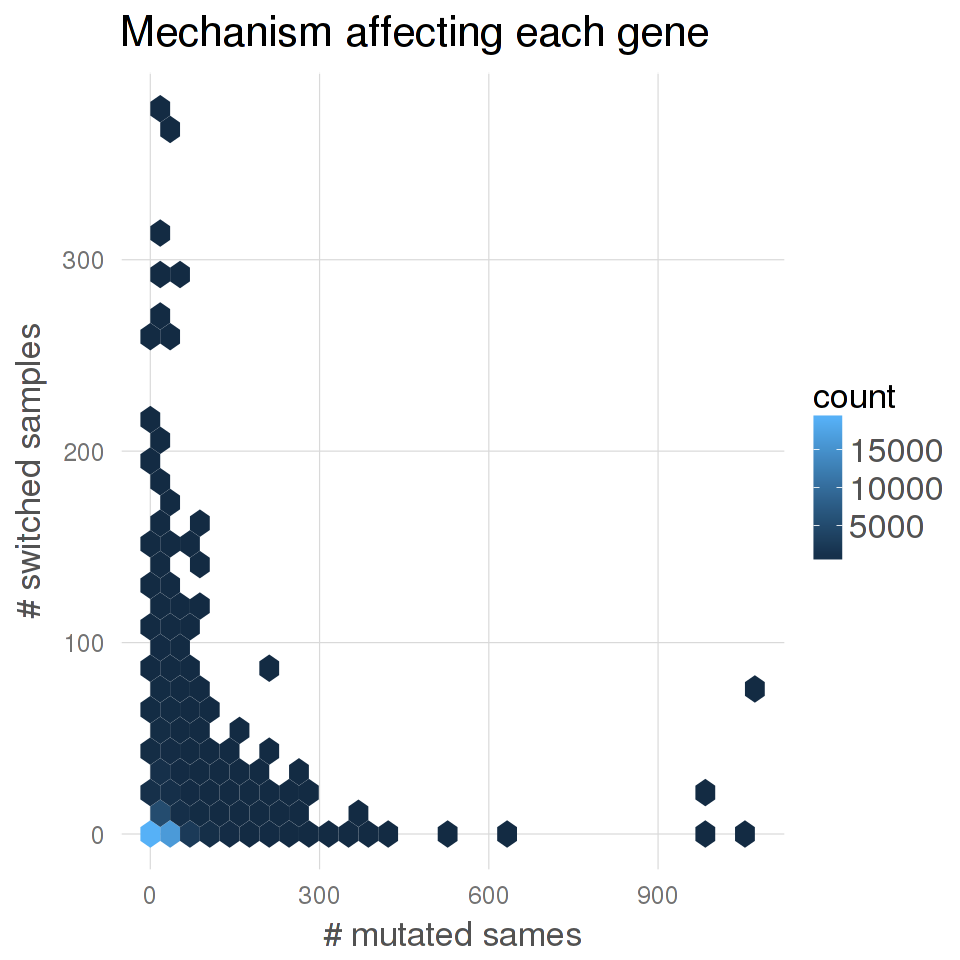

In [2]:
ggplot(wes, aes(x=M+MS,y=S+MS)) + 
    stat_binhex() +
    labs(x="# mutated sames",y="# switched samples",title="Mechanism affecting each gene") +
    clean_theme() +
    theme(legend.position="right")

Density plot of the different genes. Genes with no switch apprear only one, with its count of mutations and 0 switches. Genes with switches appear as many times as switches there are. For example TP53 appears four times (the four right-most dots). As we can see, switches and mutations rarely co-occur.

In [3]:
cor(wes$M,wes$S,method="pearson")

[1] -0.02052186

As we see, there is no correlation between switches and mutations.

## Co-occurrence
We will focus on cases where a functional switch has been described.

In [4]:
wes <- subset(wes,IsFunctional==1)

# check if co-occurrence in drivers is higher than in non-drivers
wilcox.test(wes$co[wes$Driver==1],wes$co[wes$Driver==0],alternative="greater")

summary(wes$co[wes$Driver==1])
summary(wes$co[wes$Driver==0])


	Wilcoxon rank sum test with continuity correction

data:  wes$co[wes$Driver == 1] and wes$co[wes$Driver == 0]
W = 712200, p-value = 0.002076
alternative hypothesis: true location shift is greater than 0


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00000 0.00000 0.00000 0.01636 0.00000 0.60000       1 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
0.000000 0.000000 0.000000 0.006456 0.000000 0.500000        4 

We expect drivers to harbour more mutations, which in turn could cause switches. Indeed, we observe that switches in drivers tend to co-occur with mutations slightly more than in non-drivers. This suggests that the mutations in cancer can have an impact on splicing.

## Mutual exclusion
We are interested in functional equivalence between switches and mutations. Genes with high counts of mutations and switches, as well as low counts of co-occurences could be a good indicator of it.

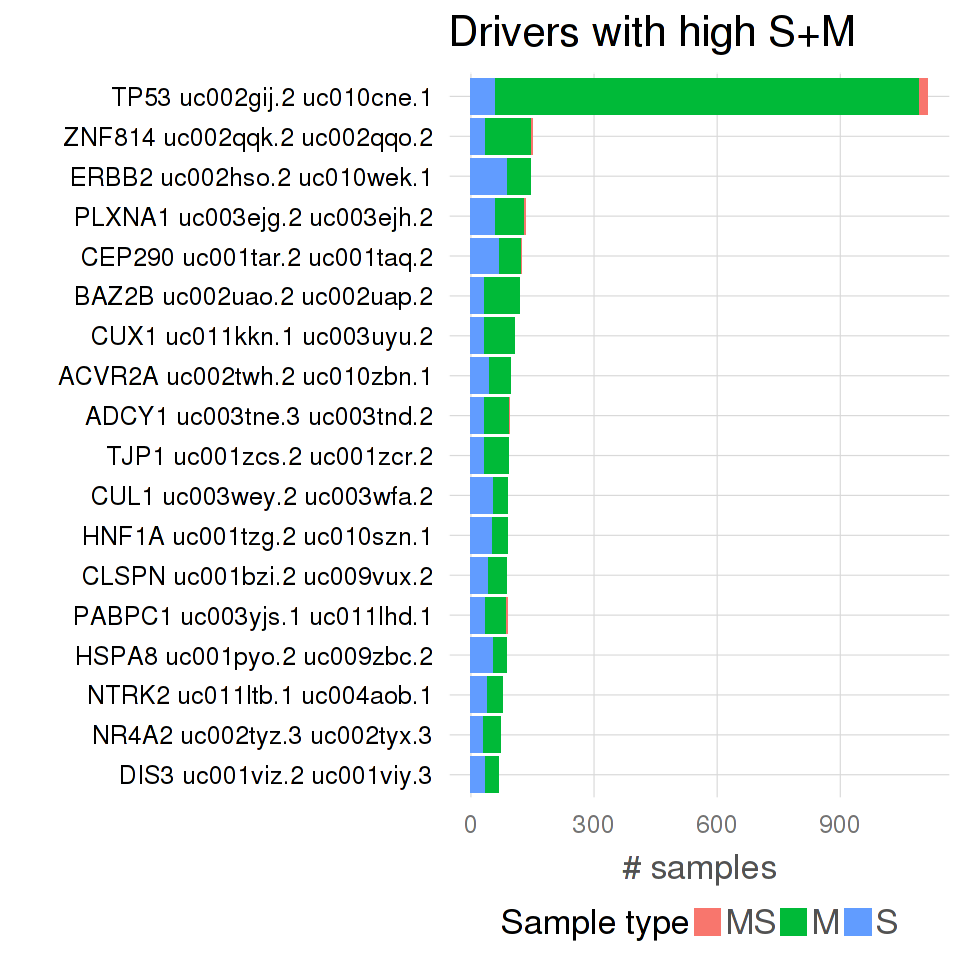

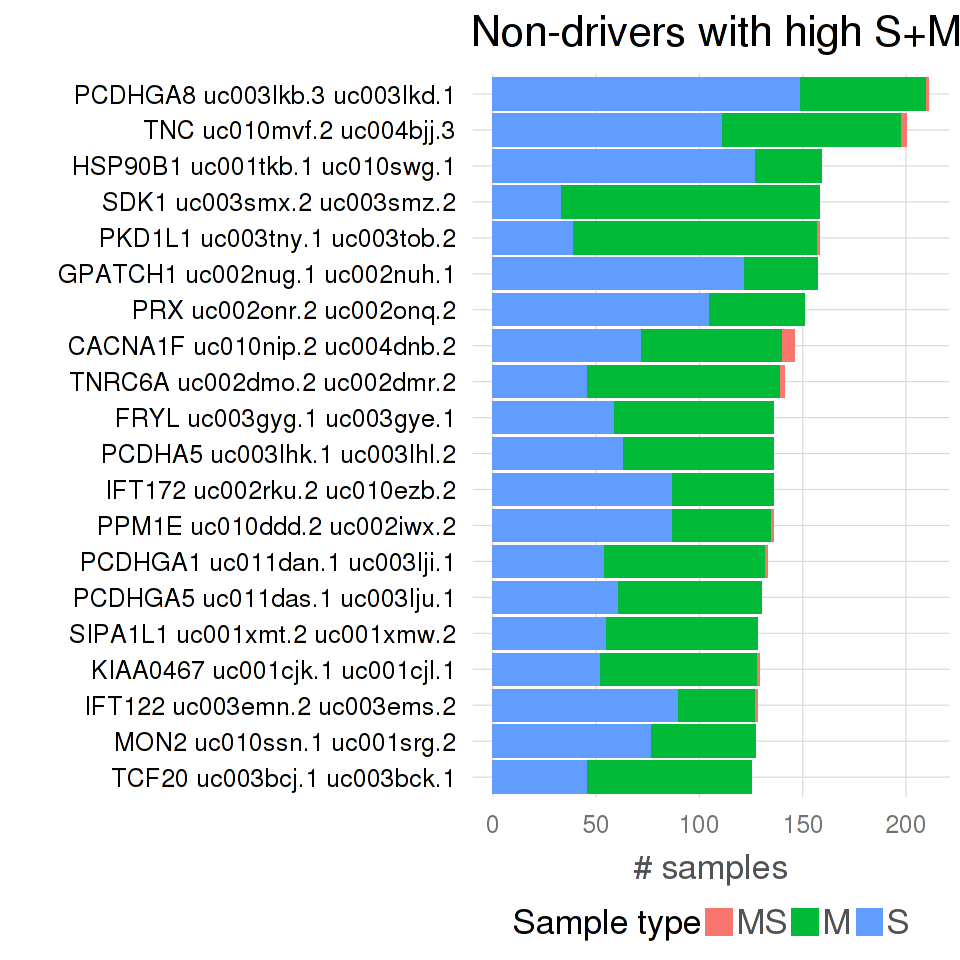

In [5]:
# remove very long genes and cases with few switches or mutations
df <- subset(wes, M > 30 & S > 30 & ! Symbol %in% c("TTN","OBSCN"))

# we order according to M+S and create the factors
df <- df %>%
    arrange(M + S) %>%
    mutate(Switch = paste(Symbol,Normal_transcript,Tumor_transcript, sep=" "),
           Switch = factor(Switch, levels=Switch))

# plot top 20 drivers
df %>%
    filter(Driver==1) %>%
    tail(n=20) %>%
    subset(select=c("Switch","MS","M","S")) %>%
    reshape2::melt(id.vars=c("Switch")) %>%
    subset(value!=0) %>%
    ggplot() + 
        geom_bar(aes(x=Switch,y=value, fill=variable),stat="identity") +
        coord_flip() +
        labs(x="", y="# samples", fill="Sample type", title="Drivers with high S+M") +
        clean_theme() +
        theme(text = element_text(size=20), legend.position="bottom", 
              axis.text.y=element_text(hjust=1,vjust=0.5,colour="black"))

# plot top 20 non-drivers
df %>%
    filter(Driver==0) %>%
    tail(n=20) %>%
    subset(select=c("Switch","MS","M","S")) %>%
    reshape2::melt(id.vars=c("Switch")) %>%
    subset(value!=0)  %>%
    ggplot() + 
        geom_bar(aes(x=Switch,y=value, fill=variable),stat="identity") +
        coord_flip() +
        labs(x="", y="# samples", fill="Sample type", title="Non-drivers with high S+M") +
        clean_theme() +
        theme(text = element_text(size=20), legend.position="bottom", 
              axis.text.y=element_text(hjust=1,vjust=0.5,colour="black"))

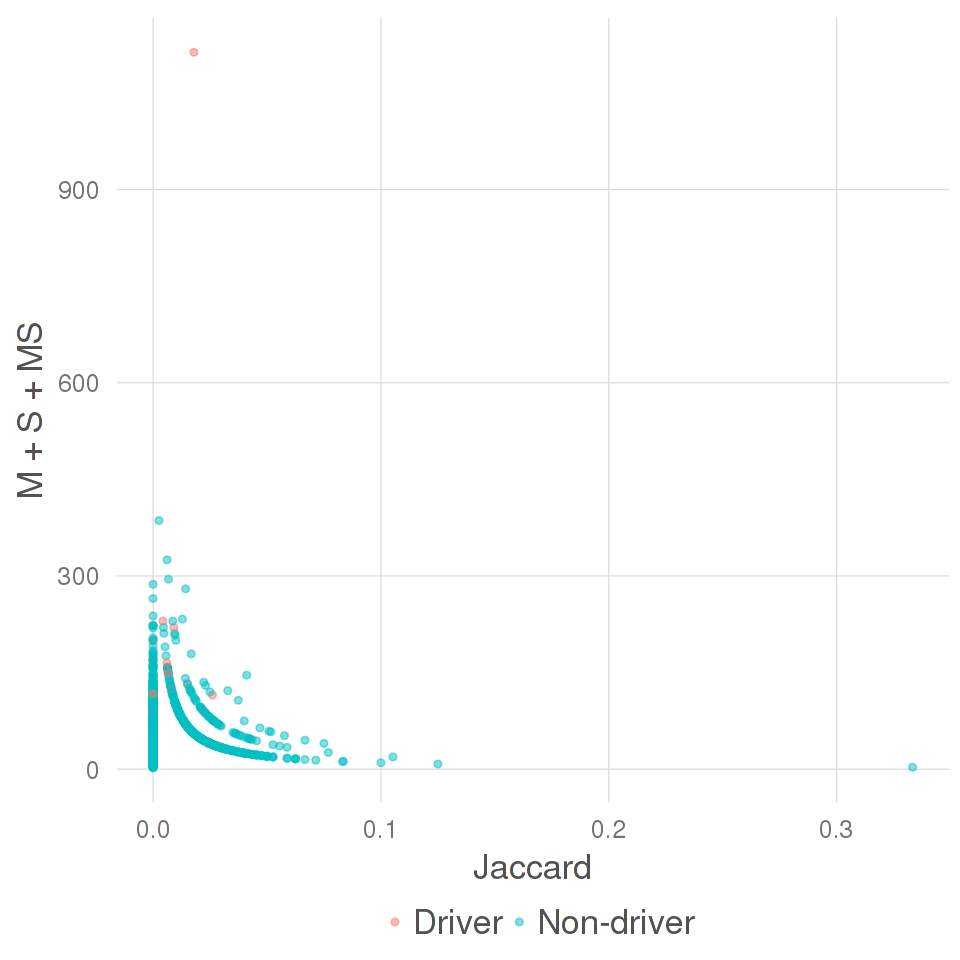

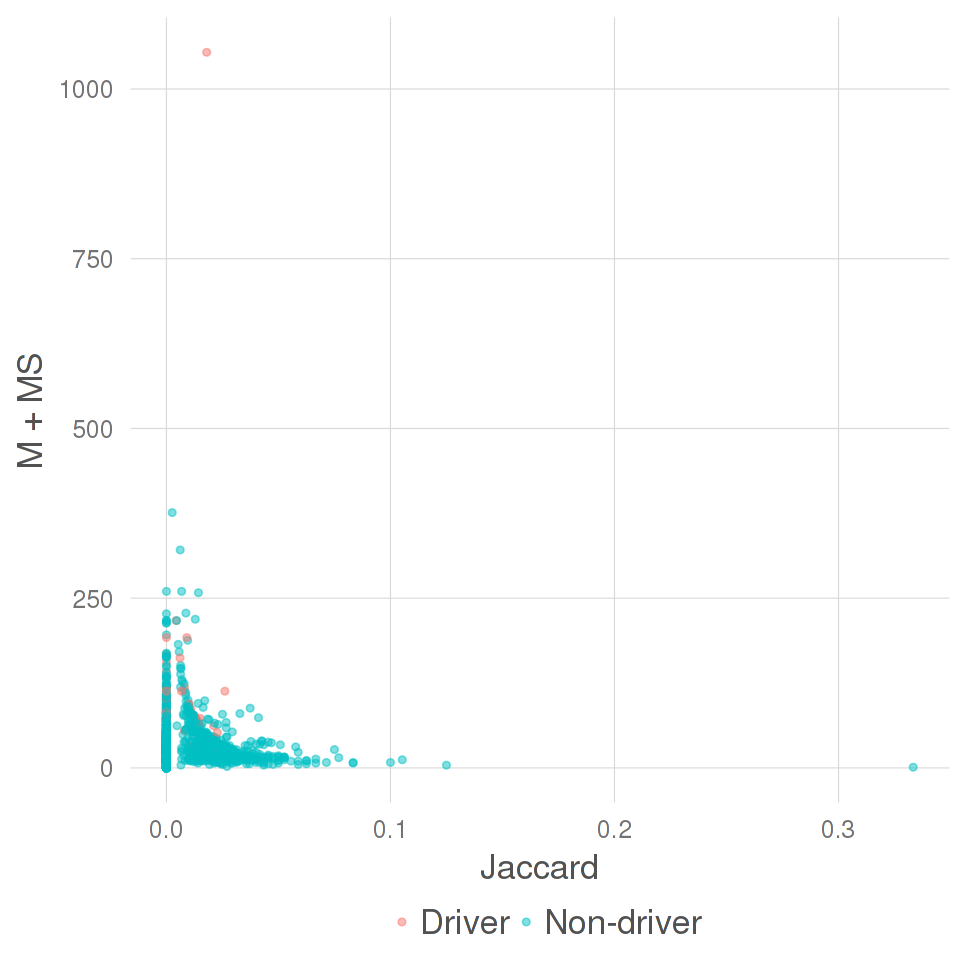

In [6]:
# some measures of mutual exclusion
wes %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    ggplot(aes(x = Jaccard, y = M + S + MS, color = ifelse(Driver==1, "Driver", "Non-driver"))) +
        geom_point(alpha = 0.5) +
        clean_theme() + 
        theme(legend.position="bottom") +
        labs(color = "")

wes %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    ggplot(aes(x = Jaccard, y = M + MS, color = ifelse(Driver==1, "Driver", "Non-driver"))) +
        geom_point(alpha = 0.5) +
        clean_theme() + 
        theme(legend.position="bottom") +
        labs(color = "")

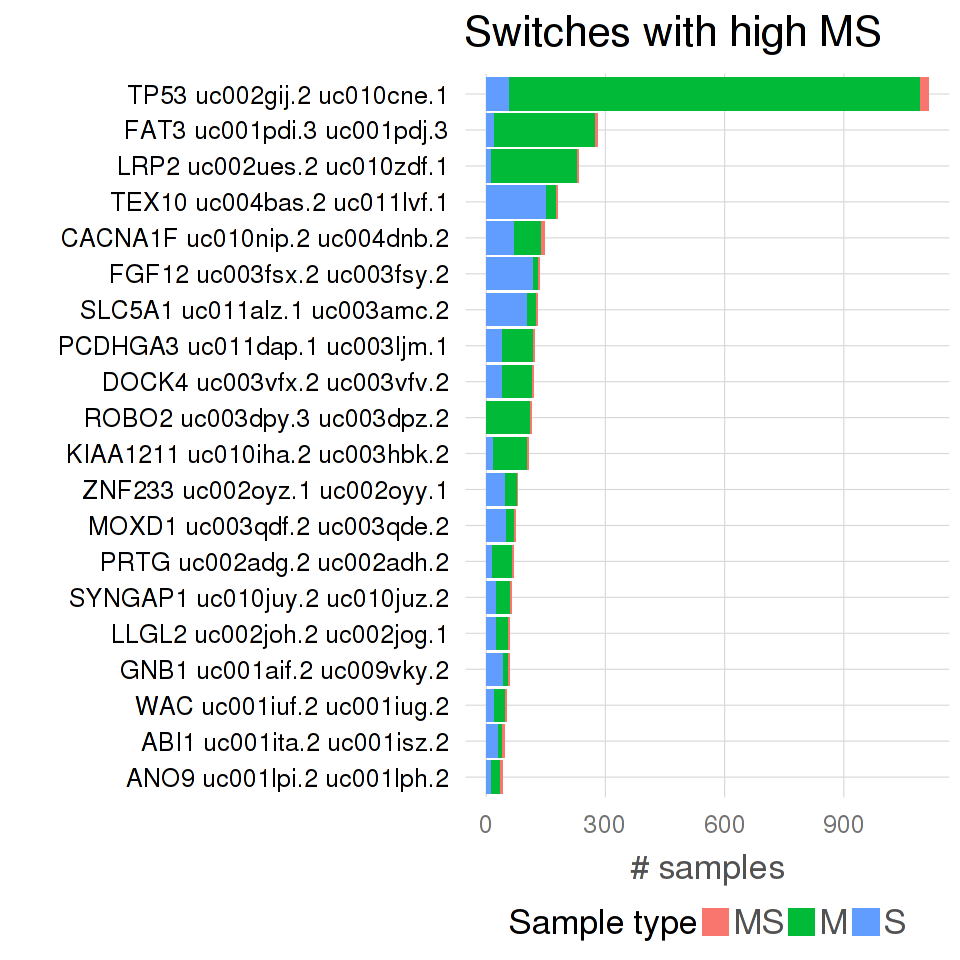

In [7]:
# plot cases with most MS
wes %>%
    # remove very long genes
    filter(! Symbol %in% c("TTN","OBSCN")) %>%
    arrange(MS) %>%
    tail(n=20) %>%
    arrange(MS + M + S) %>%
    mutate(Switch = paste(Symbol,Normal_transcript,Tumor_transcript, sep=" "),
           Switch = factor(Switch, levels=Switch)) %>%
    select(Switch,MS,M,S) %>%
    reshape2::melt(id.vars=c("Switch")) %>%
    subset(value!=0) %>%
    ggplot() + 
        geom_bar(aes(x=Switch,y=value, fill=variable),stat="identity") +
        coord_flip() +
        labs(x="", y="# samples", fill="Sample type", title="Switches with high MS") +
        clean_theme() +
        theme(text = element_text(size=20), legend.position="bottom", 
              axis.text.y=element_text(hjust=1,vjust=0.5,colour="black"))    

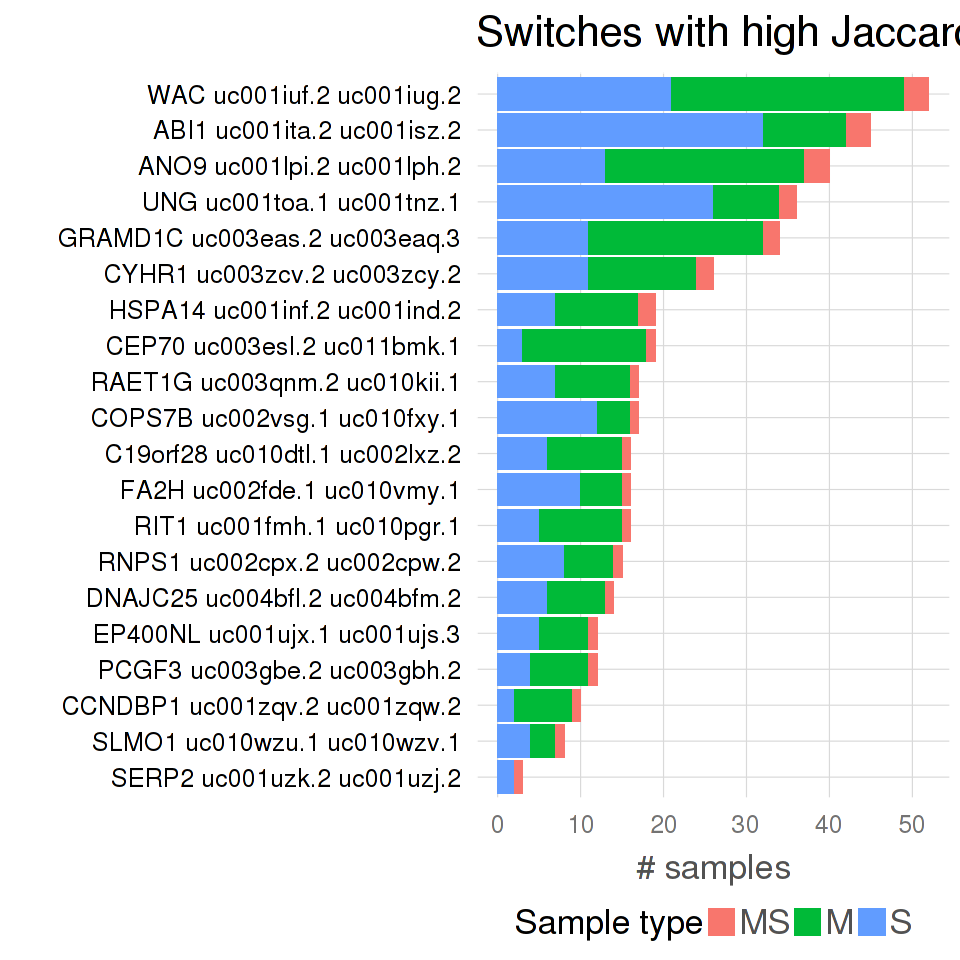

In [8]:
# plot cases with highest Jaccard
wes %>%
    # remove very long genes and cases with few switches or mutations
    filter(! Symbol %in% c("TTN","OBSCN")) %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    arrange(Jaccard) %>%
    tail(n=20) %>%
    arrange(MS + M + S) %>%
    mutate(Switch = paste(Symbol,Normal_transcript,Tumor_transcript, sep=" "),
           Switch = factor(Switch, levels=Switch)) %>%
    select(Switch,MS,M,S) %>%
    reshape2::melt(id.vars=c("Switch")) %>%
    subset(value!=0) %>%
    ggplot() + 
        geom_bar(aes(x=Switch,y=value, fill=variable),stat="identity") +
        coord_flip() +
        labs(x="", y="# samples", fill="Sample type", title="Switches with high Jaccard") +
        clean_theme() +
        theme(text = element_text(size=20), legend.position="bottom", 
              axis.text.y=element_text(hjust=1,vjust=0.5,colour="black"))    